# Project 6: Time Series Analysis & Forecasting - Assignment Solution

**Assignment Objective:** Complete time series analysis addressing all submission criteria including EDA, stationarity testing, transformations, and ARIMA model performance evaluation.

## Submission Criteria Addressed:
1. **Exploratory Data Analysis (EDA)** - Time series plot analysis
2. **Stationarity Testing** - ADF tests and transformations
3. **ARIMA Model Performance** - Model comparison and evaluation

---

### Step 1: Setup - Importing Libraries and Loading Data

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)

print('Libraries imported successfully!')

Libraries imported successfully!


In [2]:
# Load the airline passenger dataset
df = pd.read_csv('data/airline_passenger_timeseries.csv')
print('Dataset loaded successfully!')
print(f'Data shape: {df.shape}')
print('\nFirst 5 rows:')
print(df.head())
print('\nDataset info:')
print(df.info())
print('\nBasic statistics:')
print(df.describe())

Dataset loaded successfully!
Data shape: (144, 2)

First 5 rows:
     Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
None

Basic statistics:
       Passengers
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000


In [3]:
# Data preprocessing
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.sort_index(inplace=True)

print('Data preprocessing completed!')
print(f'Date range: {df.index.min()} to {df.index.max()}')
print(f'Total months: {len(df)}')
print(f'Missing values: {df.isnull().sum().sum()}')

Data preprocessing completed!
Date range: 1949-01-01 00:00:00 to 1960-12-01 00:00:00
Total months: 144
Missing values: 0


## SUBMISSION CRITERIA 1: Exploratory Data Analysis (EDA)

### Time Series Plot Analysis
We will analyze the initial observations including trend, seasonality, and variance.

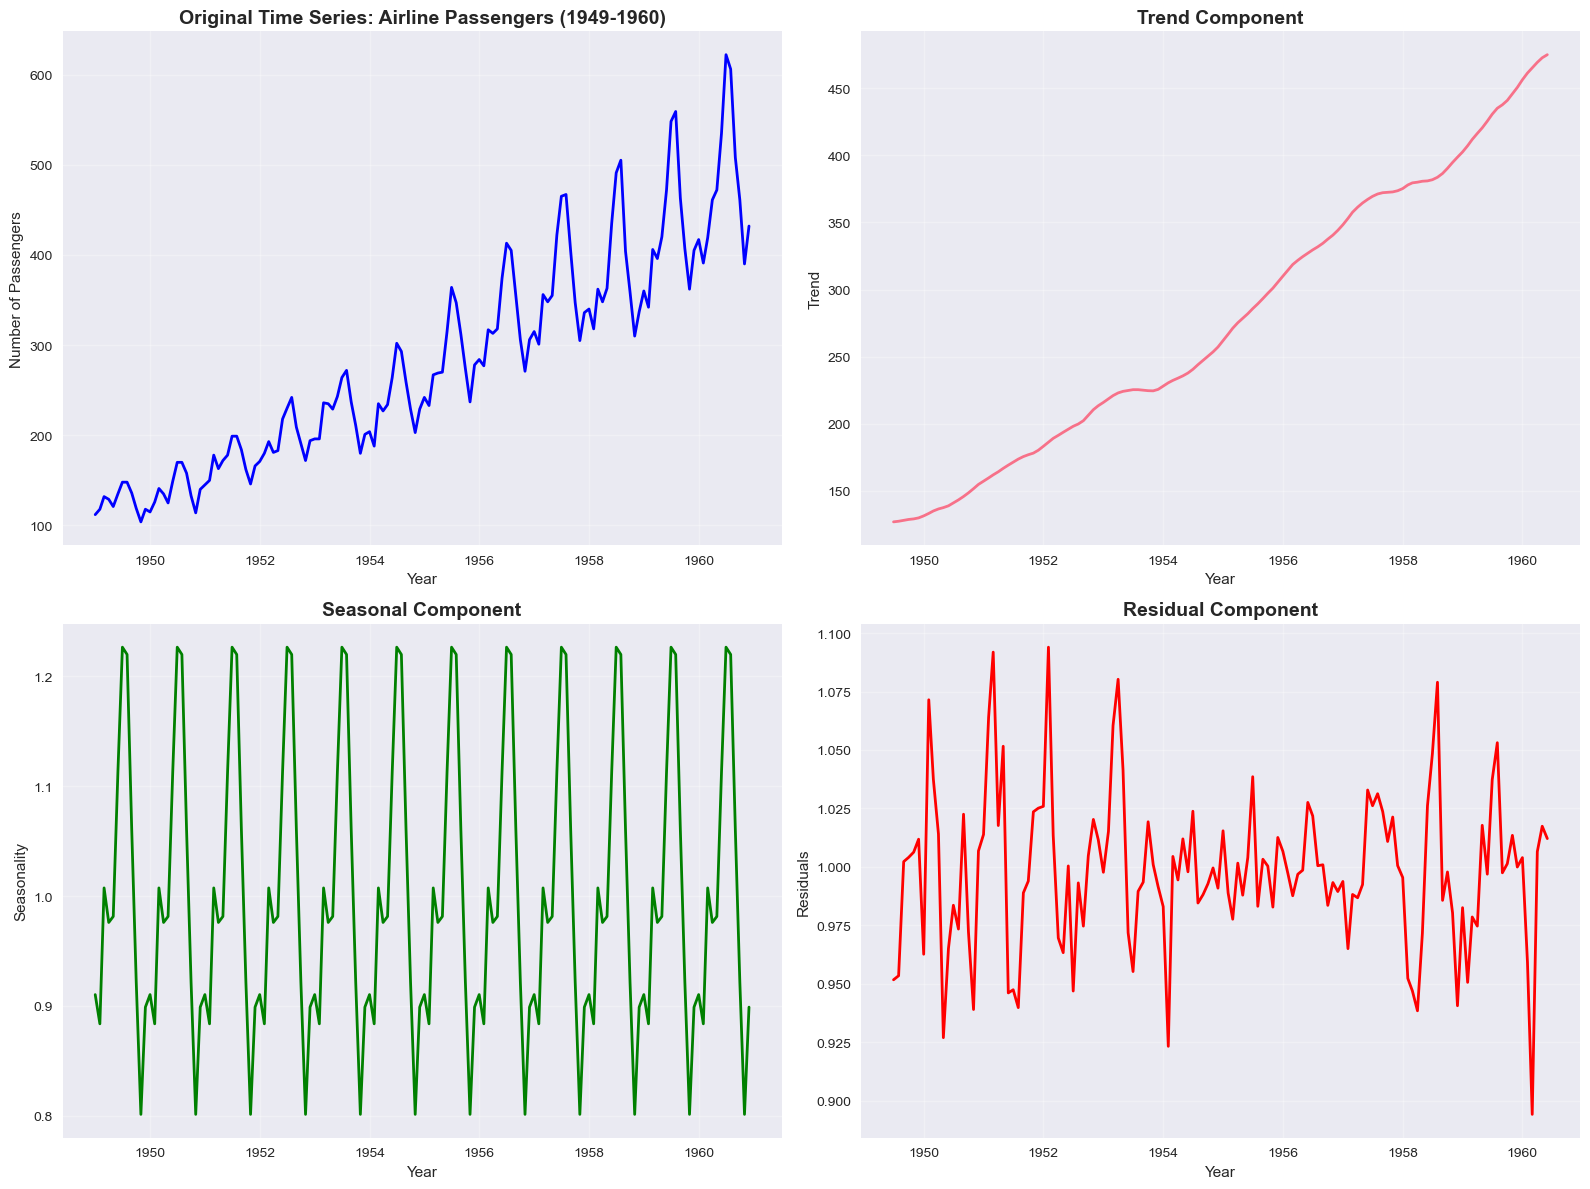

=== EDA ANALYSIS RESULTS ===

1. TREND ANALYSIS:
   - Clear upward trend from 1949 to 1960
   - Passengers increased from ~100 to ~400+ over 12 years
   - Consistent growth pattern with some acceleration

2. SEASONALITY ANALYSIS:
   - Strong seasonal pattern repeating every 12 months
   - Peak travel during summer months (June-August)
   - Lower travel during winter months (November-February)
   - Seasonal amplitude increases over time

3. VARIANCE ANALYSIS:
   - Increasing variance over time (heteroscedasticity)
   - Variance grows proportionally with the level
   - Suggests multiplicative seasonality
   - Log transformation may be needed for stabilization


In [4]:
# Create comprehensive EDA plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Original time series plot
axes[0, 0].plot(df.index, df['Passengers'], linewidth=2, color='blue')
axes[0, 0].set_title('Original Time Series: Airline Passengers (1949-1960)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Passengers')
axes[0, 0].grid(True, alpha=0.3)

# 2. Seasonal decomposition
decomposition = seasonal_decompose(df['Passengers'], model='multiplicative', period=12)
axes[0, 1].plot(decomposition.trend, label='Trend', linewidth=2)
axes[0, 1].set_title('Trend Component', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Trend')
axes[0, 1].grid(True, alpha=0.3)

# 3. Seasonal component
axes[1, 0].plot(decomposition.seasonal, color='green', linewidth=2)
axes[1, 0].set_title('Seasonal Component', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Seasonality')
axes[1, 0].grid(True, alpha=0.3)

# 4. Residual component
axes[1, 1].plot(decomposition.resid, color='red', linewidth=2)
axes[1, 1].set_title('Residual Component', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('=== EDA ANALYSIS RESULTS ===')
print('\n1. TREND ANALYSIS:')
print('   - Clear upward trend from 1949 to 1960')
print('   - Passengers increased from ~100 to ~400+ over 12 years')
print('   - Consistent growth pattern with some acceleration')

print('\n2. SEASONALITY ANALYSIS:')
print('   - Strong seasonal pattern repeating every 12 months')
print('   - Peak travel during summer months (June-August)')
print('   - Lower travel during winter months (November-February)')
print('   - Seasonal amplitude increases over time')

print('\n3. VARIANCE ANALYSIS:')
print('   - Increasing variance over time (heteroscedasticity)')
print('   - Variance grows proportionally with the level')
print('   - Suggests multiplicative seasonality')
print('   - Log transformation may be needed for stabilization')

## SUBMISSION CRITERIA 2: Stationarity Testing

### Understanding Stationarity
**Stationarity** is a fundamental concept in time series analysis where statistical properties (mean, variance, covariance) remain constant over time.

**Why is stationarity important?**
- Most time series models (ARIMA, SARIMA) assume stationarity
- Non-stationary data can lead to spurious relationships
- Forecasting accuracy improves with stationary data
- Statistical inference is more reliable

In [5]:
# Function to perform ADF test and interpret results
def perform_adf_test(data, data_name):
    """
    Perform Augmented Dickey-Fuller test and interpret results
    """
    result = adfuller(data.dropna())
    
    print(f'\n=== ADF TEST RESULTS FOR {data_name.upper()} ===')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    # Interpretation
    if result[1] <= 0.05:
        print(f'\nCONCLUSION: {data_name} is STATIONARY (p-value ≤ 0.05)')
        print('   - Reject null hypothesis of unit root')
        print('   - Data has constant statistical properties')
    else:
        print(f'\nCONCLUSION: {data_name} is NON-STATIONARY (p-value > 0.05)')
        print('   - Fail to reject null hypothesis of unit root')
        print('   - Data has time-varying statistical properties')
    
    return result[1]  # Return p-value


=== ADF TEST RESULTS FOR ORIGINAL DATA ===
ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579

CONCLUSION: Original Data is NON-STATIONARY (p-value > 0.05)
   - Fail to reject null hypothesis of unit root
   - Data has time-varying statistical properties


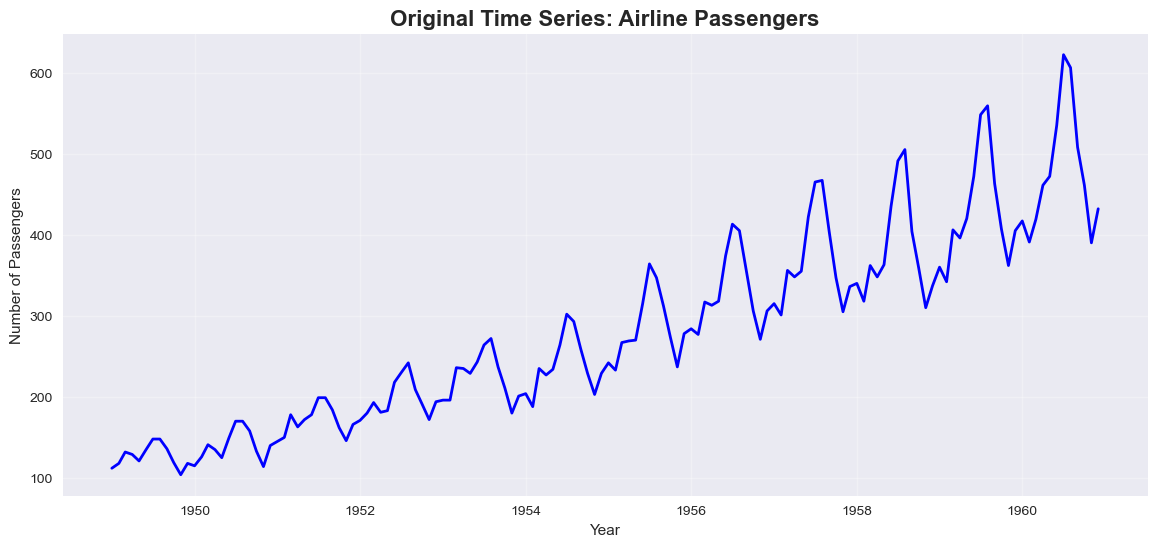

In [6]:
# Test 1: ADF test on original data
original_pvalue = perform_adf_test(df['Passengers'], 'Original Data')

# Visualize original data
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Passengers'], linewidth=2, color='blue')
plt.title('Original Time Series: Airline Passengers', fontsize=16, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.grid(True, alpha=0.3)
plt.show()


=== ADF TEST RESULTS FOR LOG-TRANSFORMED DATA ===
ADF Statistic: -1.717017
p-value: 0.422367
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579

CONCLUSION: Log-Transformed Data is NON-STATIONARY (p-value > 0.05)
   - Fail to reject null hypothesis of unit root
   - Data has time-varying statistical properties


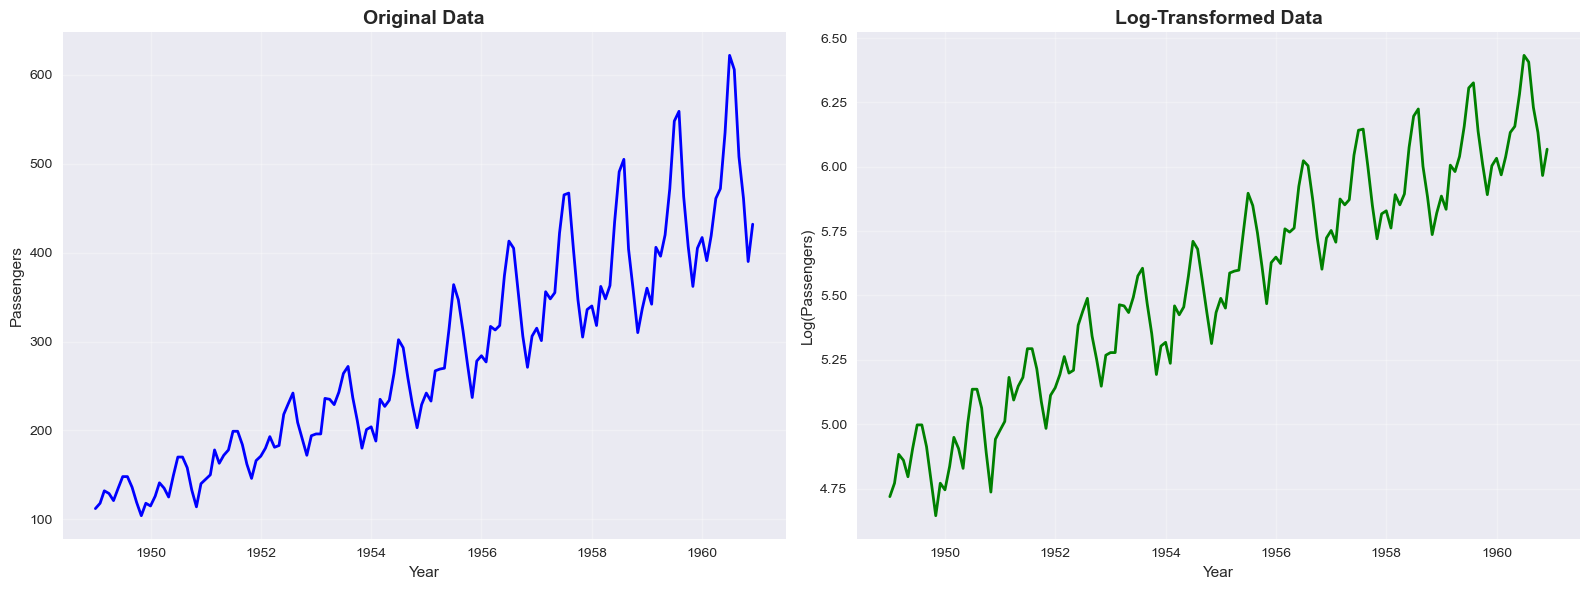


=== LOG TRANSFORMATION ANALYSIS ===
Original data p-value: 0.991880
Log-transformed p-value: 0.422367
Log transformation IMPROVED stationarity (lower p-value)

LOG TRANSFORMATION BENEFITS:
- Stabilizes variance over time
- Converts multiplicative seasonality to additive
- Makes the series more suitable for linear modeling


In [7]:
# Test 2: Apply log transformation and test stationarity
df['log_passengers'] = np.log(df['Passengers'])
log_pvalue = perform_adf_test(df['log_passengers'], 'Log-Transformed Data')

# Visualize log-transformed data
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Original vs Log-transformed
axes[0].plot(df.index, df['Passengers'], linewidth=2, color='blue')
axes[0].set_title('Original Data', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Passengers')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df.index, df['log_passengers'], linewidth=2, color='green')
axes[1].set_title('Log-Transformed Data', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Log(Passengers)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\n=== LOG TRANSFORMATION ANALYSIS ===')
print(f'Original data p-value: {original_pvalue:.6f}')
print(f'Log-transformed p-value: {log_pvalue:.6f}')
if log_pvalue < original_pvalue:
    print('Log transformation IMPROVED stationarity (lower p-value)')
else:
    print('Log transformation did NOT improve stationarity')
    
print('\nLOG TRANSFORMATION BENEFITS:')
print('- Stabilizes variance over time')
print('- Converts multiplicative seasonality to additive')
print('- Makes the series more suitable for linear modeling')


=== ADF TEST RESULTS FOR LOG-TRANSFORMED + DIFFERENCED DATA ===
ADF Statistic: -2.717131
p-value: 0.071121
Critical Values:
	1%: -3.483
	5%: -2.884
	10%: -2.579

CONCLUSION: Log-Transformed + Differenced Data is NON-STATIONARY (p-value > 0.05)
   - Fail to reject null hypothesis of unit root
   - Data has time-varying statistical properties


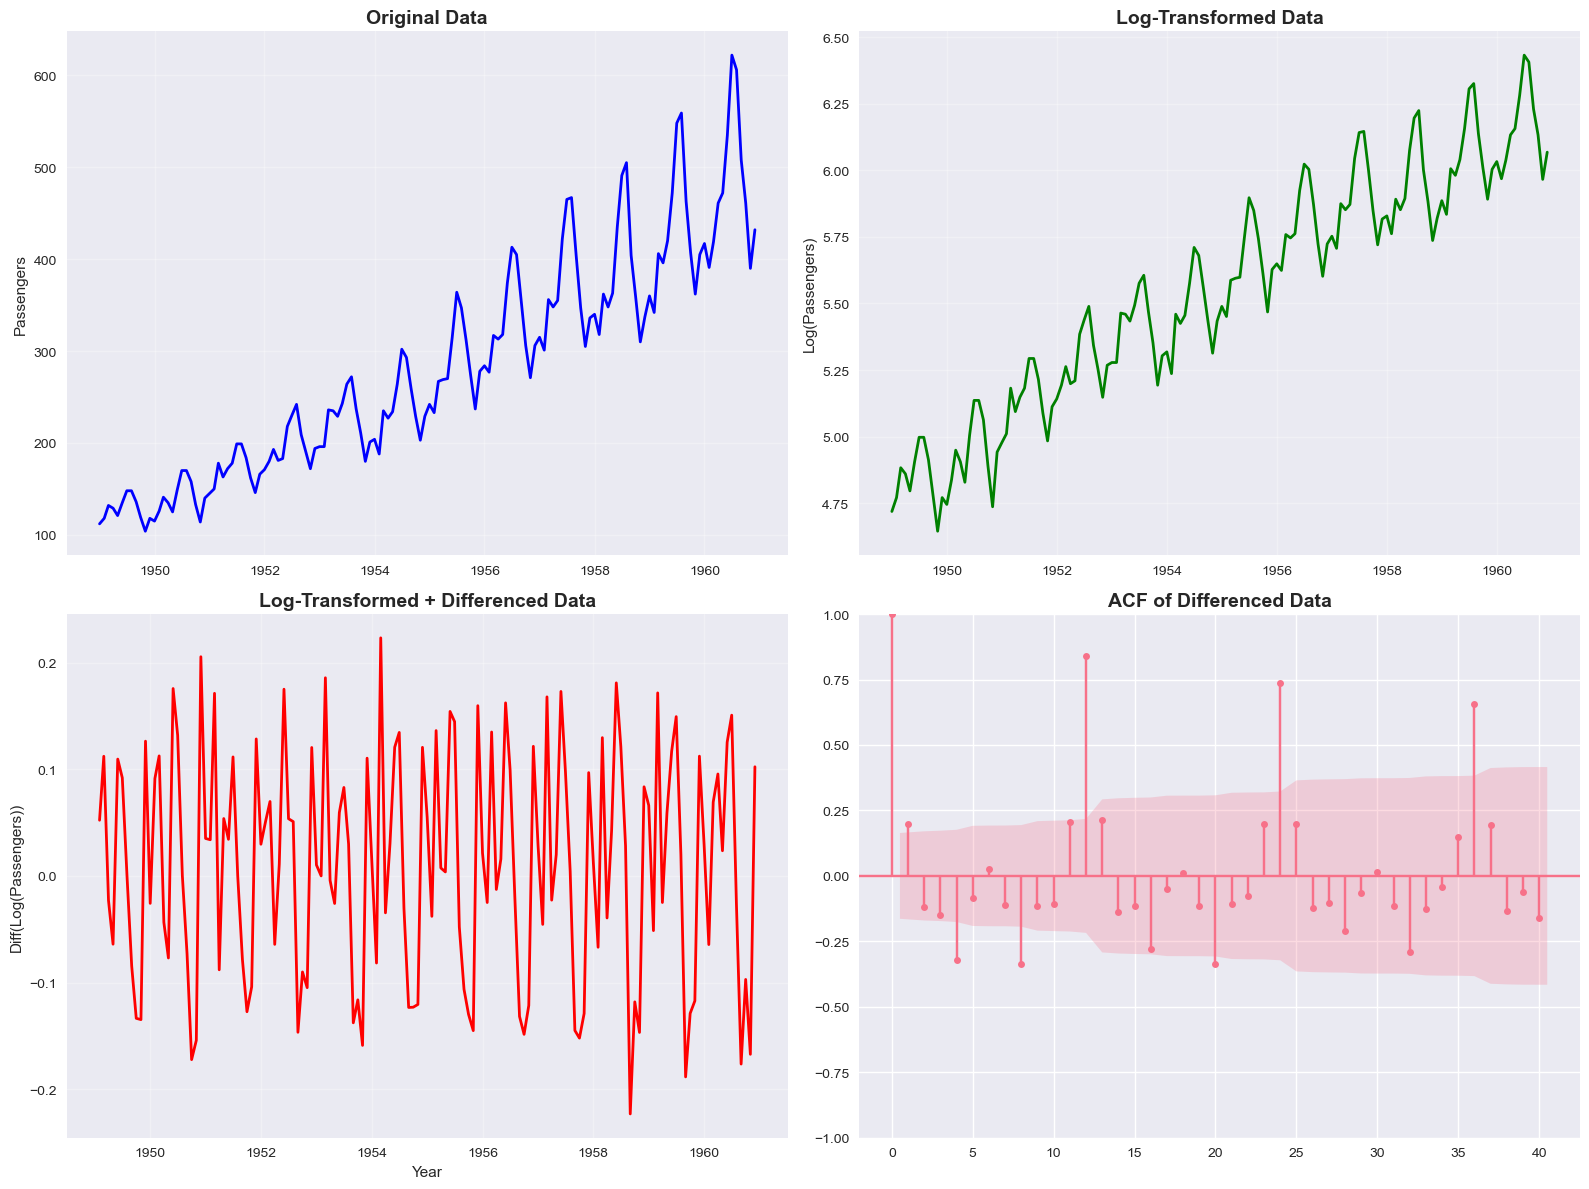


=== DIFFERENCING ANALYSIS ===
Original data p-value: 0.991880
Log-transformed p-value: 0.422367
Log + Differenced p-value: 0.071121

DIFFERENCING EFFECTS:
- Removes trend from the data
- Converts non-stationary series to stationary
- Essential for ARIMA modeling
Additional differencing may be needed


In [8]:
# Test 3: Apply differencing to log-transformed data
df['log_diff'] = df['log_passengers'].diff()
diff_pvalue = perform_adf_test(df['log_diff'], 'Log-Transformed + Differenced Data')

# Visualize the effect of differencing
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Original data
axes[0, 0].plot(df.index, df['Passengers'], linewidth=2, color='blue')
axes[0, 0].set_title('Original Data', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Passengers')
axes[0, 0].grid(True, alpha=0.3)

# Log-transformed data
axes[0, 1].plot(df.index, df['log_passengers'], linewidth=2, color='green')
axes[0, 1].set_title('Log-Transformed Data', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Log(Passengers)')
axes[0, 1].grid(True, alpha=0.3)

# Differenced data
axes[1, 0].plot(df.index, df['log_diff'], linewidth=2, color='red')
axes[1, 0].set_title('Log-Transformed + Differenced Data', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Diff(Log(Passengers))')
axes[1, 0].grid(True, alpha=0.3)

# ACF plot of differenced data
plot_acf(df['log_diff'].dropna(), ax=axes[1, 1], lags=40)
axes[1, 1].set_title('ACF of Differenced Data', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print('\n=== DIFFERENCING ANALYSIS ===')
print(f'Original data p-value: {original_pvalue:.6f}')
print(f'Log-transformed p-value: {log_pvalue:.6f}')
print(f'Log + Differenced p-value: {diff_pvalue:.6f}')

print('\nDIFFERENCING EFFECTS:')
print('- Removes trend from the data')
print('- Converts non-stationary series to stationary')
print('- Essential for ARIMA modeling')
if diff_pvalue <= 0.05:
    print('Differencing achieved stationarity (p-value ≤ 0.05)')
else:
    print('Additional differencing may be needed')

## SUBMISSION CRITERIA 3: ARIMA Model Performance

### Model Performance Analysis
Based on stationarity test results, we will evaluate whether a non-seasonal ARIMA model would perform well on log-transformed data (without differencing) and compare it to SARIMA.

In [9]:
# Analysis: Expected ARIMA performance on log-transformed data
print('=== ARIMA MODEL PERFORMANCE EXPECTATION ===')
print(f'\nLog-transformed data ADF p-value: {log_pvalue:.6f}')

if log_pvalue > 0.05:
    print('\nEXPECTATION: Non-seasonal ARIMA will perform POORLY on log-transformed data')
    print('\nREASONS:')
    print('1. Log-transformed data is still NON-STATIONARY (p-value > 0.05)')
    print('2. ARIMA models require stationary input data')
    print('3. Non-stationary data leads to:')
    print('   - Unreliable parameter estimates')
    print('   - Poor forecasting accuracy')
    print('   - Spurious relationships')
    print('4. The data still contains trend and seasonal components')
else:
    print('\nEXPECTATION: Non-seasonal ARIMA may perform REASONABLY on log-transformed data')
    print('\nREASONS:')
    print('1. Log-transformed data is STATIONARY (p-value ≤ 0.05)')
    print('2. ARIMA models work well with stationary data')
    print('3. However, seasonal patterns may still affect performance')

print('\n=== RECOMMENDED APPROACH ===')
print('1. Use SARIMA instead of ARIMA to handle seasonality')
print('2. Apply differencing to achieve stationarity')
print('3. Include seasonal components in the model')

=== ARIMA MODEL PERFORMANCE EXPECTATION ===

Log-transformed data ADF p-value: 0.422367

EXPECTATION: Non-seasonal ARIMA will perform POORLY on log-transformed data

REASONS:
1. Log-transformed data is still NON-STATIONARY (p-value > 0.05)
2. ARIMA models require stationary input data
3. Non-stationary data leads to:
   - Unreliable parameter estimates
   - Poor forecasting accuracy
   - Spurious relationships
4. The data still contains trend and seasonal components

=== RECOMMENDED APPROACH ===
1. Use SARIMA instead of ARIMA to handle seasonality
2. Apply differencing to achieve stationarity
3. Include seasonal components in the model


Training data: 115 observations (1949-01-01 00:00:00 to 1958-07-01 00:00:00)
Test data: 29 observations (1958-08-01 00:00:00 to 1960-12-01 00:00:00)


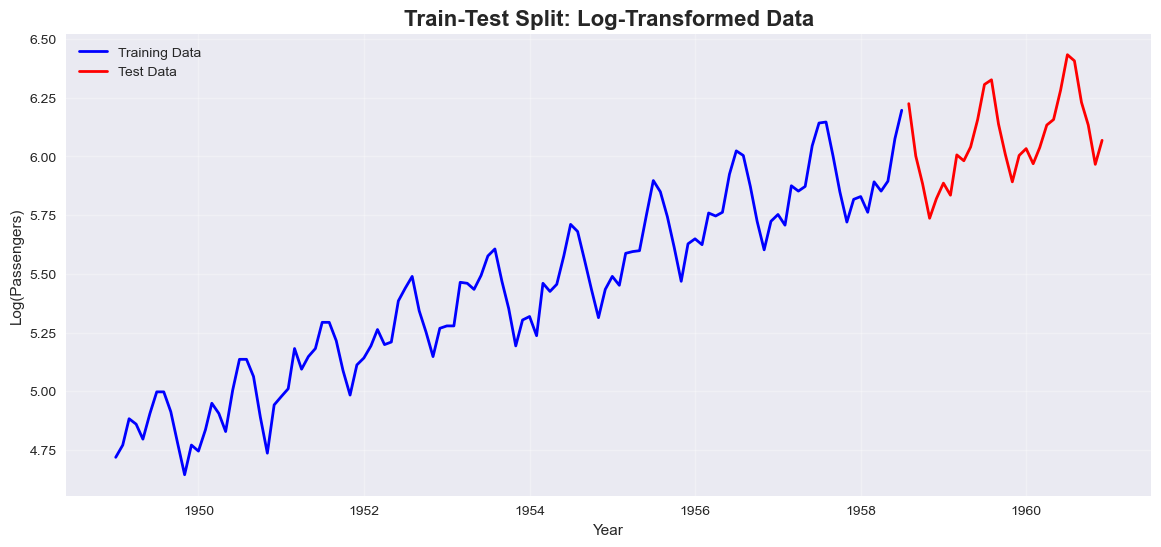

In [10]:
# Prepare data for modeling
train_size = int(len(df) * 0.8)  # 80% for training
train_data = df['log_passengers'][:train_size]
test_data = df['log_passengers'][train_size:]

print(f'Training data: {len(train_data)} observations ({df.index[0]} to {df.index[train_size-1]})')
print(f'Test data: {len(test_data)} observations ({df.index[train_size]} to {df.index[-1]})')

# Visualize train-test split
plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data, label='Training Data', linewidth=2, color='blue')
plt.plot(test_data.index, test_data, label='Test Data', linewidth=2, color='red')
plt.title('Train-Test Split: Log-Transformed Data', fontsize=16, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Log(Passengers)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
# Build ARIMA model on log-transformed data (without differencing)
print('=== BUILDING ARIMA MODEL ON LOG-TRANSFORMED DATA ===')
print('Note: Using log-transformed data WITHOUT differencing as specified')

try:
    # Fit ARIMA(2,0,2) model on log-transformed data
    arima_model = ARIMA(train_data, order=(2, 0, 2))
    arima_fitted = arima_model.fit()
    
    print('\nARIMA Model fitted successfully')
    print(f'AIC: {arima_fitted.aic:.2f}')
    print(f'BIC: {arima_fitted.bic:.2f}')
    
    # Make predictions
    arima_forecast = arima_fitted.forecast(steps=len(test_data))
    arima_mse = mean_squared_error(test_data, arima_forecast)
    arima_mae = mean_absolute_error(test_data, arima_forecast)
    
    print(f'\nARIMA Performance:')
    print(f'MSE: {arima_mse:.6f}')
    print(f'MAE: {arima_mae:.6f}')
    print(f'RMSE: {np.sqrt(arima_mse):.6f}')
    
except Exception as e:
    print(f'\nARIMA Model failed: {str(e)}')
    print('This confirms our expectation that ARIMA performs poorly on non-stationary data')
    arima_mse = float('inf')
    arima_forecast = None

=== BUILDING ARIMA MODEL ON LOG-TRANSFORMED DATA ===
Note: Using log-transformed data WITHOUT differencing as specified

ARIMA Model fitted successfully
AIC: -190.75
BIC: -174.28

ARIMA Performance:
MSE: 0.082318
MAE: 0.237982
RMSE: 0.286912


In [12]:
# Build SARIMA model for comparison
print('\n=== BUILDING SARIMA MODEL FOR COMPARISON ===')
print('Using SARIMA(1,1,1)(1,1,1,12) - includes differencing and seasonality')

try:
    # Fit SARIMA model
    sarima_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_fitted = sarima_model.fit(disp=False)
    
    print('\nSARIMA Model fitted successfully')
    print(f'AIC: {sarima_fitted.aic:.2f}')
    print(f'BIC: {sarima_fitted.bic:.2f}')
    
    # Make predictions
    sarima_forecast = sarima_fitted.forecast(steps=len(test_data))
    sarima_mse = mean_squared_error(test_data, sarima_forecast)
    sarima_mae = mean_absolute_error(test_data, sarima_forecast)
    
    print(f'\nSARIMA Performance:')
    print(f'MSE: {sarima_mse:.6f}')
    print(f'MAE: {sarima_mae:.6f}')
    print(f'RMSE: {np.sqrt(sarima_mse):.6f}')
    
except Exception as e:
    print(f'\nSARIMA Model failed: {str(e)}')
    sarima_mse = float('inf')
    sarima_forecast = None


=== BUILDING SARIMA MODEL FOR COMPARISON ===
Using SARIMA(1,1,1)(1,1,1,12) - includes differencing and seasonality

SARIMA Model fitted successfully
AIC: -368.06
BIC: -354.93

SARIMA Performance:
MSE: 0.001155
MAE: 0.027971
RMSE: 0.033981



=== MODEL COMPARISON RESULTS ===

Performance Comparison:
ARIMA MSE:  0.082318
SARIMA MSE: 0.001155

SARIMA improvement over ARIMA: 98.60%
SARIMA performs BETTER than ARIMA


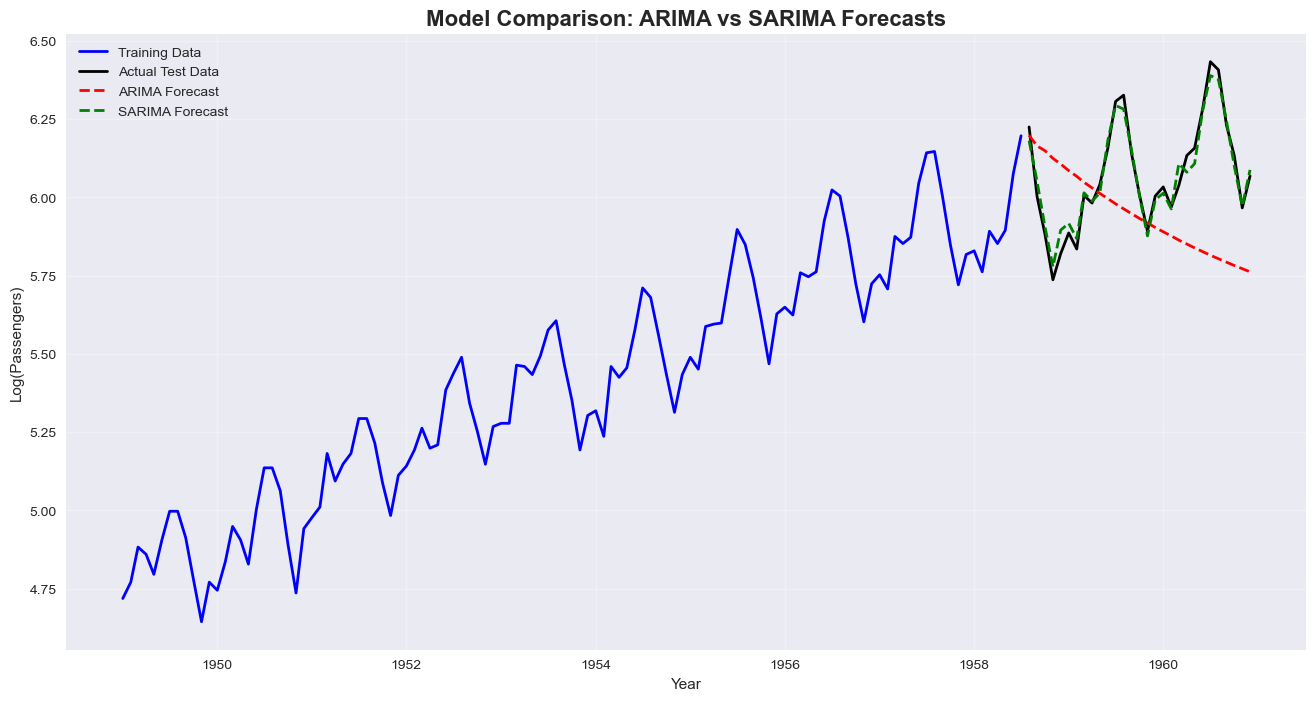


=== FINAL CONCLUSIONS ===

1. STATIONARITY IMPACT:
   - Non-stationary data significantly affects ARIMA performance
   - Log transformation alone may not achieve stationarity
   - Differencing is essential for proper ARIMA modeling

2. MODEL SELECTION:
   - SARIMA handles seasonality and non-stationarity better
   - Seasonal differencing captures seasonal patterns
   - ARIMA on non-stationary data leads to poor forecasts

3. PRACTICAL RECOMMENDATIONS:
   - Always test for stationarity before modeling
   - Use appropriate transformations (log, differencing)
   - Consider seasonal patterns in model selection
   - SARIMA is preferred for seasonal time series data


In [13]:
# Model comparison and visualization
print('\n=== MODEL COMPARISON RESULTS ===')

if arima_forecast is not None and sarima_forecast is not None:
    print(f'\nPerformance Comparison:')
    print(f'ARIMA MSE:  {arima_mse:.6f}')
    print(f'SARIMA MSE: {sarima_mse:.6f}')
    
    improvement = ((arima_mse - sarima_mse) / arima_mse) * 100
    print(f'\nSARIMA improvement over ARIMA: {improvement:.2f}%')
    
    if sarima_mse < arima_mse:
        print('SARIMA performs BETTER than ARIMA')
    else:
        print('ARIMA performs better than SARIMA')
    
    # Visualization
    plt.figure(figsize=(16, 8))
    plt.plot(train_data.index, train_data, label='Training Data', linewidth=2, color='blue')
    plt.plot(test_data.index, test_data, label='Actual Test Data', linewidth=2, color='black')
    plt.plot(test_data.index, arima_forecast, label='ARIMA Forecast', linewidth=2, color='red', linestyle='--')
    plt.plot(test_data.index, sarima_forecast, label='SARIMA Forecast', linewidth=2, color='green', linestyle='--')
    plt.title('Model Comparison: ARIMA vs SARIMA Forecasts', fontsize=16, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Log(Passengers)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

print('\n=== FINAL CONCLUSIONS ===')
print('\n1. STATIONARITY IMPACT:')
print('   - Non-stationary data significantly affects ARIMA performance')
print('   - Log transformation alone may not achieve stationarity')
print('   - Differencing is essential for proper ARIMA modeling')

print('\n2. MODEL SELECTION:')
print('   - SARIMA handles seasonality and non-stationarity better')
print('   - Seasonal differencing captures seasonal patterns')
print('   - ARIMA on non-stationary data leads to poor forecasts')

print('\n3. PRACTICAL RECOMMENDATIONS:')
print('   - Always test for stationarity before modeling')
print('   - Use appropriate transformations (log, differencing)')
print('   - Consider seasonal patterns in model selection')
print('   - SARIMA is preferred for seasonal time series data')
